In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv(r"E:\quora insincere  data\train.csv")

In [6]:
df.columns

Index(['qid', 'question_text', 'target', 'num_words', 'num_unique_words',
       'num_stopwords'],
      dtype='object')

In [4]:
df["num_words"] = df["question_text"].apply(lambda x: len(str(x).split()))
df["num_words"] = df["question_text"].apply(lambda x: len(str(x).split()))
df["num_unique_words"] = df["question_text"].apply(lambda x: len(set(str(x).split())))
eng_stopwords = set(stopwords.words("english"))
df["num_stopwords"] = df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if
w in eng_stopwords]))

In [5]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['question_text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████| 1306122/1306122 [10:56<00:00, 1989.63it/s]


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc

### BOW

In [30]:
X=preprocessed_reviews[:]
y=df['target'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
# print(X_train_bow.shape, y_train.shape)


### Logistic Regression

In [34]:
parametersx=[{'C': [10**-4, 10**-2,0.75, 0.81, 1, 5, 10, 20, 50, 10**2, 10**4]}]
clf = GridSearchCV(LogisticRegression(penalty='l1'), parametersx, cv=4, scoring='roc_auc', )
clf.fit(X_train_bow, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_bow)
score=roc_auc_score(y_train, pred)
c_value=clf.best_params_['C']
# depth=clf.best_params_['max_depth']
print("best estimator: ", clf.best_estimator_)
print("Train Score: ", clf.score(X_train_bow, y_train))
print("Test Score: ", clf.score(X_test_bow, y_test))

best estimator:  LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train Score:  0.9582481439110248
Test Score:  0.9458257976751142


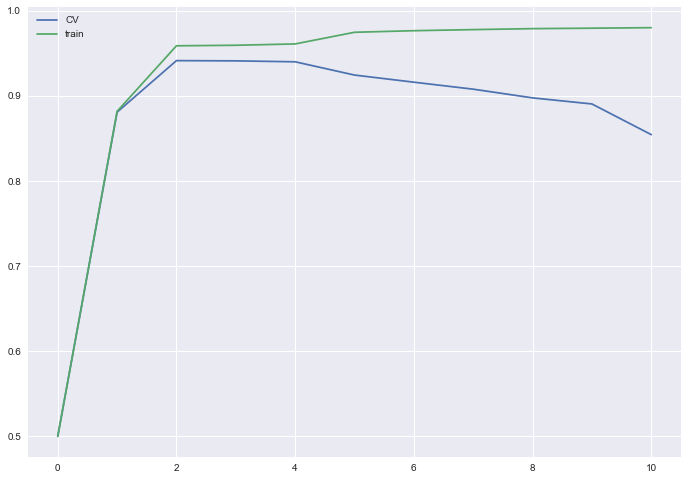

In [35]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

The best score for AUC is equal to:  0.9458246297397241
The best score for AUC is equal to:  0.9582467575081123
ROC SCORE ON BEST HYPER-PARAMETERS:  0.7167828352115645


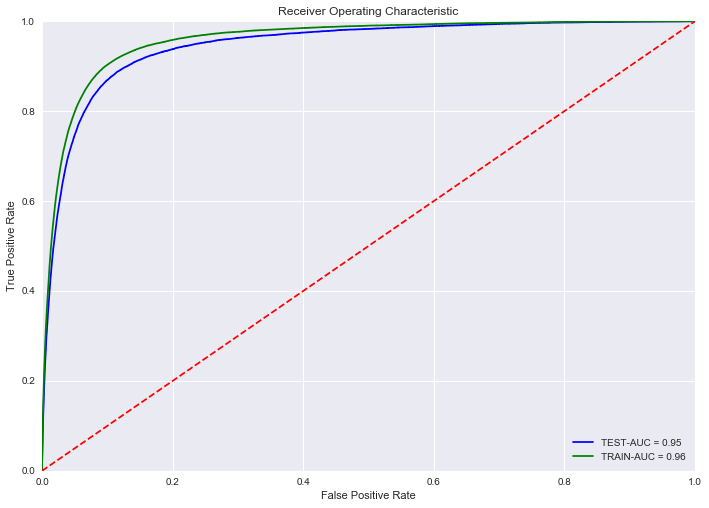

In [37]:
lr = LogisticRegression(C=c_value, penalty='l1')
lr.fit(X_train_bow, y_train)
pred1=lr.predict_proba(X_test_bow)[:,1]
pred2=lr.predict_proba(X_train_bow)[:,1]


print('The best score for AUC is equal to: ', roc_auc_score(y_test, pred1))
print('The best score for AUC is equal to: ', roc_auc_score(y_train, pred2))

score1=roc_auc_score(y_test, pred1)
score2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr1, tpr1, threshold = roc_curve(y_test, pred1)
fpr2, tpr2, threshold = roc_curve(y_train, pred2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % score1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % score2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

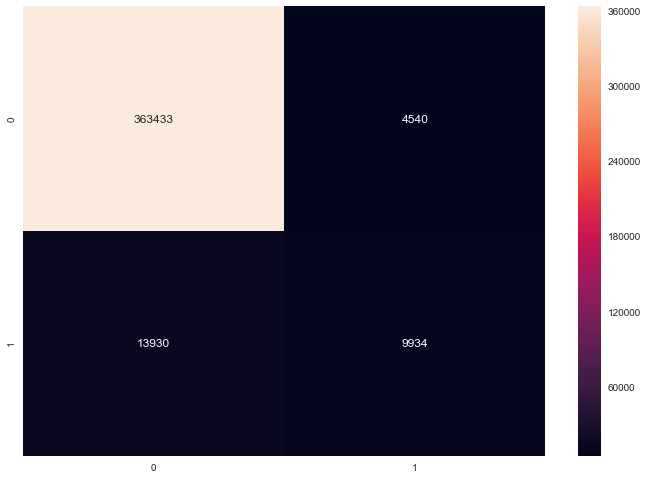

In [38]:
# plot_confusion_matrix(cm)  
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [39]:
clf = LogisticRegression(C=0.1, penalty='l2');
clf.fit(X_train_bow, y_train);
w = clf.coef_
print(w.shape)
print(np.count_nonzero(w))

(1, 148584)
148584


In [40]:
clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_train_bow, y_train);
w=clf.coef_
print(w.shape)
print(np.count_nonzero(w))

(1, 148584)
2101


In [41]:
## Pertubation Test
# from scipy.sparse import csr_matrix
print(np.count_nonzero(w))
e=0.1
# X_train_bow_dash=X_train_bow.data+=0.001
# X_train_bow_pert=csr_matrix(X_test_bow, dtype=np.float64)
# X_train_bow_dash=X_test_bow_pert[np.nonzero(X_train_bow_pert)+0.01]
# # X_train_bow_dash=X_test_bow.todense()
type(X_train_bow)

2101


scipy.sparse.csr.csr_matrix

In [42]:
X_train_bow.shape, y_train.shape

((914285, 148584), (914285,))

In [43]:
clf=LogisticRegression(penalty='l2')
clf.fit(X_train_bow, y_train)
pred=clf.predict_proba(X_test_bow)[:, 1]
w_dash=clf.coef_
print(clf.score(X_train_bow, y_train))
print(clf.score(X_test_bow, y_test))

0.9578030920336656
0.9529268547891088


In [44]:
w_dash_0=np.percentile(w_dash,0)
w_dash_25=np.percentile(w_dash,25)
w_dash_50=np.percentile(w_dash,50)
w_dash_75=np.percentile(w_dash,75)
print(w_dash_0, w_dash_25, w_dash_50, w_dash_75)
print('-'*50)
w_0=np.percentile(w,0)
w_25=np.percentile(w,25)
w_50=np.percentile(w,50)
w_75=np.percentile(w,75)
print(w_0, w_25, w_50, w_75)

-2.078679612836076 -0.05343898823247875 -0.015364568968319166 -0.0036152193579692205
--------------------------------------------------
-1.2666105004949448 0.0 0.0 0.0


In [45]:
print('percentage change in 0th percentile : ', (abs(w_0-w_dash_0)/w_0)*100)
print('percentage change in 25th percentile : ', (abs(w_25-w_dash_25)/w_25)*100)
print('percentage change in 50th percentile : ', (abs(w_50-w_dash_50)/w_50)*100)
print('percentage change in 75th percentile : ', (abs(w_75-w_dash_75)/w_75)*100)

percentage change in 0th percentile :  -64.11356230062867
percentage change in 25th percentile :  inf
percentage change in 50th percentile :  inf
percentage change in 75th percentile :  inf


In [46]:
x = pd.DataFrame(w, columns=bow_features).T
x.shape

(148584, 1)

In [50]:
print('top 10 features for  class 1: \n', x[0].sort_values(ascending=False)[0:10])

top 10 features for  class 1: 
 castrate       5.013015
castrated      4.862933
castration     4.662738
fuck           3.064640
idiots         3.021026
homosexuals    2.939944
incest         2.907122
liberals       2.892419
feminists      2.863349
blacks         2.837653
Name: 0, dtype: float64


MemoryError: 

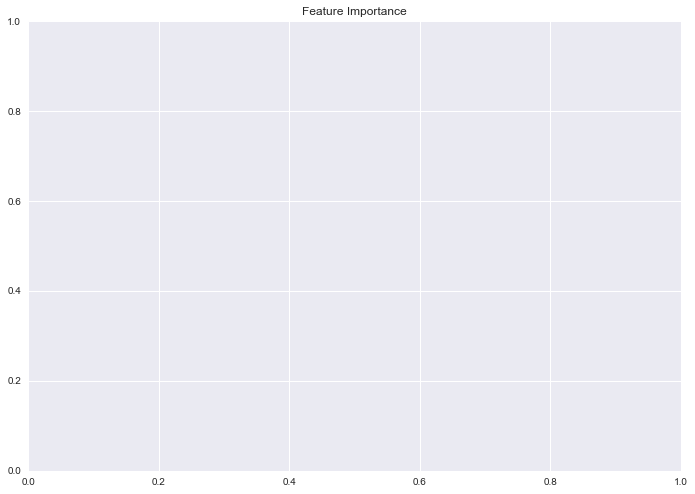

In [51]:
bow_features=bow.get_feature_names()
d = dict(zip(bow_features, w))
# total=len(d.values())
# zeros=np.count_nonzero(w)
# https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Sort feature importances in descending order
indices = np.argsort(w)[::-1][:10]

# Rearrange feature names so they match the sorted feature importances
# names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(10), w[indices])

# Add feature names as x-axis labels
names = np.array(bow_features)
plt.xticks(range(10), names[indices], rotation=10)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [49]:
print('top 10 features for  class 0: \n', x[0].sort_values(ascending=True)[:10])

top 10 features for  class 0: 
 tips          -1.266611
differences   -1.162889
difference    -1.130242
engineering   -1.061887
study         -0.953194
best          -0.950926
marks         -0.918126
data          -0.913278
differ        -0.894638
affect        -0.892134
Name: 0, dtype: float64


### Decision Trees

In [15]:


depth=[2,3,4,5,6,7,8,9,10]
sample_split=[2,3,4,5,6,7,8,9]
parameters=dict(max_depth=depth,min_samples_split=sample_split)
clf=RandomizedSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_bow, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_bow)
score=roc_auc_score(y_train, pred)
split=clf.best_params_['min_samples_split']
depth=clf.best_params_['max_depth']

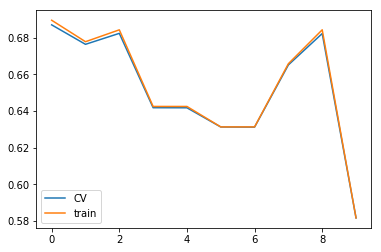

In [16]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  10
Best value of min_samples_split:  6
ROC SCORE ON BEST HYPER-PARAMETERS:  0.5928466631447129


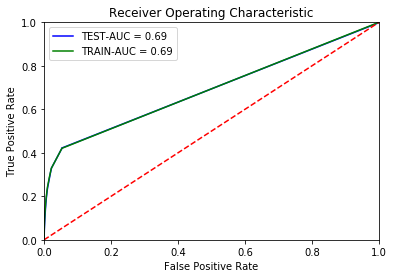

In [27]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', split)
model=tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
model.fit(X_train_bow, y_train)

w=model.feature_importances_
pred1=model.predict_proba(X_test_bow)[:,1]
pred2=model.predict_proba(X_train_bow)[:,1]
score1=roc_auc_score(y_test, pred1)
score2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr1, tpr1, threshold = roc_curve(y_test, pred1)
fpr2, tpr2, threshold = roc_curve(y_train, pred2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % score1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % score2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

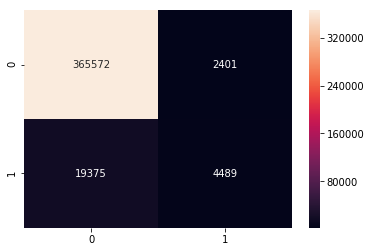

In [28]:
# plot_confusion_matrix(cm)  
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


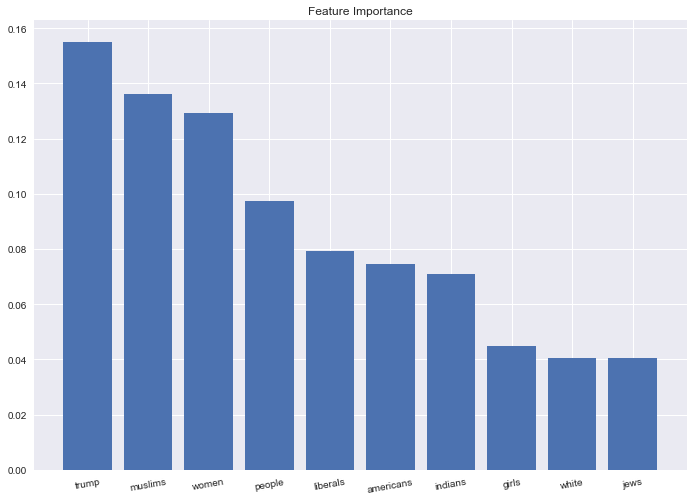

In [29]:
# print('top 10 features for -ve class: \n', df[1].sort_values(ascending=False)[:10])
bow_features=bow.get_feature_names()
d = dict(zip(bow_features, w))
# total=len(d.values())
# zeros=np.count_nonzero(w)
# https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Sort feature importances in descending order
indices = np.argsort(w)[::-1][:10]

# Rearrange feature names so they match the sorted feature importances
# names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(10), w[indices])

# Add feature names as x-axis labels
names = np.array(bow_features)
plt.xticks(range(10), names[indices], rotation=10)

# Show plot
plt.show()
# uni_gram.get_feature_names()